# 02. Using Harmony to Subset SWOT Simulated Data
### **Objectives of this Jupyter notebook**
1. Use a Harmony request to obtain a temporal and spatial subset of L2 altimetric data.
2. Construct and submit the Harmony request by using the harmony-py library.
3. Open the data in xarray and make a simple plot to visually confirm the download and subset.

### **Why are we using Harmony here?** https://harmony.earthdata.nasa.gov/
1. The advantage of reducing data size for access/download, especially for long global time series.
2. Harmony allows us to access data from different NASA DAACs in a consistent way (not DAAC-specific).
3. A number of different services like spatial subset, variable subset, etc., can all be called from Harmony

### **Datasets of interest in this notebook**
- Nadir GLORYS CalVal: https://podaac.jpl.nasa.gov/dataset/SWOT_SIMULATED_L2_NADIR_SSH_GLORYS_CALVAL_V1
- Nadir GLORYS Science: https://podaac.jpl.nasa.gov/dataset/SWOT_SIMULATED_L2_NADIR_SSH_GLORYS_SCIENCE_V1
- Nadir ECCO CalVal: https://podaac.jpl.nasa.gov/dataset/SWOT_SIMULATED_L2_NADIR_SSH_ECCO_LLC4320_CALVAL_V1
- Nadir ECCO Science: https://podaac.jpl.nasa.gov/dataset/SWOT_SIMULATED_L2_NADIR_SSH_ECCO_LLC4320_SCIENCE_V1
- KaRIn GLORYS CalVal: https://podaac.jpl.nasa.gov/dataset/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_CALVAL_V1
- KaRIn GLORYS Science: https://podaac.jpl.nasa.gov/dataset/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1
- KaRIn ECCO CalVal: https://podaac.jpl.nasa.gov/dataset/SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_CALVAL_V1
- KaRIn ECCO Science: https://podaac.jpl.nasa.gov/dataset/SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_SCIENCE_V1

#### **Import libraries**
Note: Install harmony-py to your Python environment before you can import it for the first time. See https://github.com/nasa/harmony-py


In [1]:
import xarray as xr
import numpy as np
from IPython.display import display, JSON
from datetime import datetime, timedelta, time

# highlight the harmony-py library
from harmony import BBox, Client, Collection, Request, Environment, LinkType 

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

%matplotlib inline

#### **Let's start up the client from the harmony-py library.**

In [2]:
# Start the Harmony Client.

harmony_client = Client(env=Environment.PROD)

# "PROD" stands for production. This is the environment for users.

## **Temporal and spatial subset using a bounding box around CA Crossover region**
1. Define the **collection** of interest by calling Collection(id = YourCollection), where YourCollection is a collection short name or concept-id.
2. Set **time bounds**.
3. Set **spatial bounding box**.
4. There are also other options such as variables, granules, and concatenation.

In [3]:
collection = Collection(id='SWOT_SIMULATED_L2_NADIR_SSH_GLORYS_SCIENCE_V1')

start_day = datetime(2015,4,15,0,0,0)
end_day = datetime(2015,4,20,0,0,0)

request = Request(
    collection=collection,
    temporal={
        'start': start_day,
        'stop': end_day
    },
    spatial=BBox(-140, 20, -100, 50), # [20-50N], [140W-100W] CA Current crossover point (35N,125W)
    # variables=[],
    # granule_id=granuleIDs,
    # concatenate = True,
)

request.is_valid()

True

In [4]:
print(harmony_client.request_as_curl(request))
job_id = harmony_client.submit(request)
print(f'Job ID: {job_id}') # This job id is shareable:show how to do this

curl -X GET -H 'Accept: */*' -H 'Accept-Encoding: gzip, deflate, br' -H 'Connection: keep-alive' -H 'Cookie: urs_user_already_logged=yes; token=*****; _urs-gui_session=4f208576cd57e635f4649bb4cca9da9d' -H 'User-Agent: CPython/3.9.10 Linux/5.4.156-83.273.amzn2.x86_64 python-requests/2.27.1 harmony-py/0.4.1' 'https://harmony.earthdata.nasa.gov/SWOT_SIMULATED_L2_NADIR_SSH_GLORYS_SCIENCE_V1/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?forceAsync=true&subset=lat%2820%3A50%29&subset=lon%28-140%3A-100%29&subset=time%28%222015-04-15T00%3A00%3A00%22%3A%222015-04-20T00%3A00%3A00%22%29'
Job ID: afb341e0-84ac-4c8b-9eee-eca0e2cedec2


#### **View the job status**
A Harmony request is limited to 200 granules. The limit is there to prevent users from accidentally make huge requests.

In [5]:
harmony_client.status(job_id) 

{'status': 'running',
 'message': 'The job is being processed',
 'progress': 0,
 'created_at': datetime.datetime(2022, 3, 15, 0, 45, 29, 808000, tzinfo=tzlocal()),
 'updated_at': datetime.datetime(2022, 3, 15, 0, 45, 33, 443000, tzinfo=tzlocal()),
 'created_at_local': '2022-03-15T00:45:29+00:00',
 'updated_at_local': '2022-03-15T00:45:33+00:00',
 'request': 'https://harmony.earthdata.nasa.gov/SWOT_SIMULATED_L2_NADIR_SSH_GLORYS_SCIENCE_V1/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?forceAsync=true&subset=lat(20%3A50)&subset=lon(-140%3A-100)&subset=time(%222015-04-15T00%3A00%3A00%22%3A%222015-04-20T00%3A00%3A00%22)',
 'num_input_granules': 141}

In [6]:
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


#### **Download subsetted files**

Filenames that end with "subsetted.nc4" have been subsetted. 

The other filenames (that are un-altered) indicate that these were rounded up as relevant files during Harmony's search, but do not contain data in the actual region of interest, so the files downloaded here are empty.

In [8]:
futures = harmony_client.download_all(job_id, directory='./swot_ocean_basic_subset', overwrite=True)
file_names = [f.result() for f in futures]
sorted(file_names)

['./swot_ocean_basic_subset/SWOT_GPR_2PTP018_359_20150414_234202_20150415_003327.nc4',
 './swot_ocean_basic_subset/SWOT_GPR_2PTP018_360_20150415_003328_20150415_012454_subsetted.nc4',
 './swot_ocean_basic_subset/SWOT_GPR_2PTP018_361_20150415_012455_20150415_021621.nc4',
 './swot_ocean_basic_subset/SWOT_GPR_2PTP018_362_20150415_021622_20150415_030747_subsetted.nc4',
 './swot_ocean_basic_subset/SWOT_GPR_2PTP018_363_20150415_030748_20150415_035914.nc4',
 './swot_ocean_basic_subset/SWOT_GPR_2PTP018_364_20150415_035915_20150415_045041.nc4',
 './swot_ocean_basic_subset/SWOT_GPR_2PTP018_365_20150415_045042_20150415_054208.nc4',
 './swot_ocean_basic_subset/SWOT_GPR_2PTP018_366_20150415_054209_20150415_063335.nc4',
 './swot_ocean_basic_subset/SWOT_GPR_2PTP018_367_20150415_063336_20150415_072502.nc4',
 './swot_ocean_basic_subset/SWOT_GPR_2PTP018_368_20150415_072503_20150415_081628.nc4',
 './swot_ocean_basic_subset/SWOT_GPR_2PTP018_369_20150415_081629_20150415_090755.nc4',
 './swot_ocean_basic_su

In [9]:
from os import listdir
from os.path import isfile, join
data_files = [ f for f in file_names if "subsetted" in f]
data_files

['./swot_ocean_basic_subset/SWOT_GPR_2PTP018_360_20150415_003328_20150415_012454_subsetted.nc4',
 './swot_ocean_basic_subset/SWOT_GPR_2PTP018_459_20150418_132642_20150418_141809_subsetted.nc4',
 './swot_ocean_basic_subset/SWOT_GPR_2PTP018_461_20150418_150936_20150418_160102_subsetted.nc4',
 './swot_ocean_basic_subset/SWOT_GPR_2PTP018_472_20150419_003532_20150419_012657_subsetted.nc4',
 './swot_ocean_basic_subset/SWOT_GPR_2PTP018_474_20150419_021825_20150419_030951_subsetted.nc4',
 './swot_ocean_basic_subset/SWOT_GPR_2PTP018_487_20150419_132712_20150419_141839_subsetted.nc4',
 './swot_ocean_basic_subset/SWOT_GPR_2PTP018_489_20150419_151007_20150419_160132_subsetted.nc4',
 './swot_ocean_basic_subset/SWOT_GPR_2PTP018_375_20150415_132511_20150415_141637_subsetted.nc4',
 './swot_ocean_basic_subset/SWOT_GPR_2PTP018_377_20150415_150804_20150415_155930_subsetted.nc4',
 './swot_ocean_basic_subset/SWOT_GPR_2PTP018_388_20150416_003359_20150416_012524_subsetted.nc4',
 './swot_ocean_basic_subset/SW

#### **Take a look at the subset data**
Note: xarray is a little clunky with variables in groups.

In [11]:
ds = xr.open_mfdataset(sorted(data_files),combine='nested',concat_dim='time',group='data_01')
ds

<xarray.Dataset>
Dimensions:                            (time: 9147)
Coordinates:
    latitude                           (time) float64 dask.array<chunksize=(526,), meta=np.ndarray>
    longitude                          (time) float64 dask.array<chunksize=(526,), meta=np.ndarray>
  * time                               (time) datetime64[ns] 2015-04-15T00:44...
Data variables: (12/31)
    time_tai                           (time) datetime64[ns] dask.array<chunksize=(526,), meta=np.ndarray>
    surface_classification_flag        (time) float32 dask.array<chunksize=(526,), meta=np.ndarray>
    rad_side_1_surface_type_flag       (time) float32 dask.array<chunksize=(526,), meta=np.ndarray>
    rad_side_2_surface_type_flag       (time) float32 dask.array<chunksize=(526,), meta=np.ndarray>
    alt_qual                           (time) float32 dask.array<chunksize=(526,), meta=np.ndarray>
    rad_qual                           (time) float32 dask.array<chunksize=(526,), meta=np.ndarray>
    ...                                 ...
    pole_tide                          (time) float32 dask.array<chunksize=(526,), meta=np.ndarray>
    internal_tide                      (time) float32 dask.array<chunksize=(526,), meta=np.ndarray>
    wind_speed_alt                     (time) float32 dask.array<chunksize=(526,), meta=np.ndarray>
    wind_speed_alt_mle3                (time) float32 dask.array<chunksize=(526,), meta=np.ndarray>
    rad_water_vapor                    (time) float32 dask.array<chunksize=(526,), meta=np.ndarray>
    rad_cloud_liquid_water             (time) float32 dask.array<chunksize=(526,), meta=np.ndarray>

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


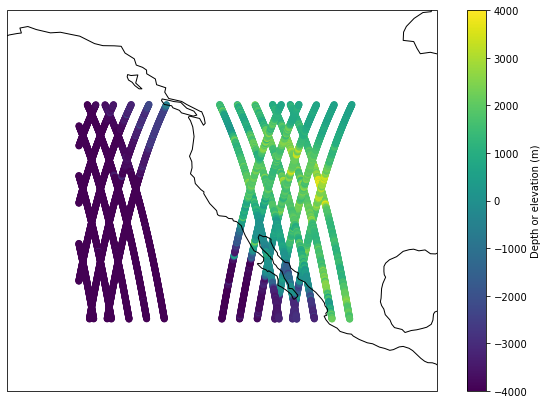

In [13]:
fig = plt.figure(figsize=[11,7]) 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-150, -90, 10, 60])
plt.scatter(ds.longitude, ds.latitude, lw=1, c=ds.depth_or_elevation)
plt.colorbar(label='Depth or elevation (m)')
plt.clim(-4000,4000)
plt.show()
# ds.plot.scatter( y="latitude",
#                  x="longitude", 
#                  hue="depth_or_elevation",
#                  s=1,
#                  vmin=-4000,
#                  vmax=4000,
#                  levels=9, 
#                  cmap="jet",
#                  aspect=2.5,
#                  size=9, )

#### **Next: Try subsetting by variable or granule IDs, or over a longer time period**